# __5.2 Genome sequencing over time__

Goal:
- Determine the number of genomes (nuclear or organellar) sequenced over time

Data:
- [NCBI viridiplantae genome summary](https://www.ncbi.nlm.nih.gov/genome/?term=txid33090[Organism:exp])
  - Searched on 10/28/22, this is not useful, limited info without dates.
- [NCBI datahub on viridiplantae genome](https://www.ncbi.nlm.nih.gov/data-hub/genome/?taxon=33090)
  - Searched on 10/28/22, ncbi_dataset.tsv

Thoughts
- Summary stat
  - 2384 assemblies that are not redundant (i.e., with different assembly accession numbers).
  - Number of organisms: 1231
  - Number of genus: 559
- Issue with missing wGS accession
  - Some assembies do not have WGS assession info. 
  - Also, some assemblies are updated (e.g., Arabidopsis) and the date is the update date.

## ___Setup___

### Import

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from datetime import datetime


### Key variables

In [89]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "5_species_over_time/"
work_dir.mkdir(parents=True, exist_ok=True)

genomes_tsv = work_dir / 'ncbi_dataset.tsv'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Analysis___

### Read ncbi_dataset.tsv

In [42]:
genomes_data = pd.read_csv(genomes_tsv, sep='\t')
genomes_data.head(4)

,Assembly Accession,Assembly Name,Assembly Accession.1,Organism Name,Assembly Submission Date
0,GCF_003935025.1,Abrus_2018,GCF_003935025.1,Abrus precatorius,2018-12-11
1,GCA_003935025.1,Abrus_2018,GCA_003935025.1,Abrus precatorius,2018-12-11
2,GCA_024086825.1,ASM2408682v1,GCA_024086825.1,Abrus pulchellus subsp. cantoniensis,2022-07-06
3,GCA_023634445.1,ASM2363444v1,GCA_023634445.1,Abrus pulchellus subsp. cantoniensis,2022-06-02


In [43]:
# Get assession, sp name, and date. WGS project accession is used to weed out
# redundant entries. Note that assembly assession is not useful because there
# can be different assembly versions
genomes_sp_dt = genomes_data[['Assembly Name', 'Organism Name', 
                              'Assembly Submission Date']]
genomes_sp_dt.head()


,Assembly Name,Organism Name,Assembly Submission Date
0,Abrus_2018,Abrus precatorius,2018-12-11
1,Abrus_2018,Abrus precatorius,2018-12-11
2,ASM2408682v1,Abrus pulchellus subsp. cantoniensis,2022-07-06
3,ASM2363444v1,Abrus pulchellus subsp. cantoniensis,2022-06-02
4,ASM1902265v1,Acacia acuminata,2021-06-24


### Rid of redundant entries

In [46]:
indices   = genomes_sp_dt.index
acc_dict  = {}
not_redun = []
for idx in indices:
  acc = genomes_sp_dt['Assembly Name'].loc[idx]
  #print(idx, [acc], acc not in acc_dict)
  if acc not in acc_dict:
    acc_dict[acc] = 0
    not_redun.append(1)
  else:
    not_redun.append(0)

In [47]:
genomes_sp_dt.shape, len(not_redun)

((2625, 3), 2625)

In [48]:
# https://stackoverflow.com/questions/42379818/correct-way-to-set-new-column-in-pandas-dataframe-to-avoid-settingwithcopywarnin
genomes_sp_dt['Not redun'] = not_redun

# Tried the following but still get the warning
#genomes_sp_dt.loc[:,"Not redun"] = not_redun
genomes_sp_dt.head(2)

/tmp/ipykernel_252/4087055652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_sp_dt['Not redun'] = not_redun


,Assembly Name,Organism Name,Assembly Submission Date,Not redun
0,Abrus_2018,Abrus precatorius,2018-12-11,1
1,Abrus_2018,Abrus precatorius,2018-12-11,0


In [49]:
genomes_sp_dt_nr = genomes_sp_dt[genomes_sp_dt['Not redun'] == 1]
genomes_sp_dt_nr.shape

(2384, 4)

In [50]:
genomes_sp_dt_nr.head(10)

,Assembly Name,Organism Name,Assembly Submission Date,Not redun
0,Abrus_2018,Abrus precatorius,2018-12-11,1
2,ASM2408682v1,Abrus pulchellus subsp. cantoniensis,2022-07-06,1
3,ASM2363444v1,Abrus pulchellus subsp. cantoniensis,2022-06-02,1
4,ASM1902265v1,Acacia acuminata,2021-06-24,1
5,ASM1902261v1,Acacia melanoxylon,2021-06-24,1
6,ASM2556357v1,Acacia pycnantha,2022-10-06,1
7,ASM1991499v1,Acanthochlamys bracteata,2021-09-09,1
8,ASM2559438v1,Acer negundo,2022-10-06,1
9,AYv1.1,Acer yangbiense,2019-08-23,1
10,ASM966300v1,Actinidia chinensis,2019-11-14,1


### Number of genus and species

In [51]:

def count_num_org_genus(org_names):
  '''Determine teh number of organisms and genus given a list of organism names
  Args:
    org_names (list): org names with genus and in some cases species or isolate
      info.
  Return:
    org_counts (dict): {organism: count}
    genus_counts (dict): {genus: count}
  ''' 

  org_counts   = {} # {organism: count}
  genus_counts = {} # {genus: count}

  for name in org_names:
    genus = name.split(' ')[0]
    if name not in org_counts:
      org_counts[name] = 1
    else:
      org_counts[name]+= 1

    if genus not in genus_counts:
      genus_counts[genus] = 1
    else:
      genus_counts[genus]+= 1

  return org_counts, genus_counts

In [52]:
org_names = genomes_sp_dt_nr['Organism Name'].values
org_counts, genus_counts = count_num_org_genus(org_names)

In [53]:
print(f"Organisms:{len(org_counts)}, genus:{len(genus_counts)}")

Organisms:1231, genus:559


### Add a year column

In [58]:
dt_strs = genomes_sp_dt_nr['Assembly Submission Date']
dt_yrs  = [int(dt_str.split('-')[0]) for dt_str in dt_strs]
genomes_sp_dt_nr["Year"] = dt_yrs
genomes_sp_dt_nr.head(2)

/tmp/ipykernel_252/274666305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomes_sp_dt_nr["Year"] = dt_yrs


,Assembly Name,Organism Name,Assembly Submission Date,Not redun,Year
0,Abrus_2018,Abrus precatorius,2018-12-11,1,2018
2,ASM2408682v1,Abrus pulchellus subsp. cantoniensis,2022-07-06,1,2022


### Get counts for different years

In [59]:
# only include records till 2020
yrs = np.unique(dt_yrs)[:-2]
yrs

array([2004, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

In [67]:
count_yr_dict = {} # {yr:[num_org_yr, num_gen_yr]}
org_yr_list = []
gen_yr_list = []
for yr in yrs:
  org_nm_yr = genomes_sp_dt_nr[genomes_sp_dt_nr['Year'] == yr]['Organism Name']
  org_counts_yr, genus_counts_yr = count_num_org_genus(org_nm_yr)
  num_org_yr = len(org_counts_yr)
  num_gen_yr = len(genus_counts_yr)
  count_yr_dict[yr] = [num_org_yr, num_gen_yr]
  org_yr_list.append(num_org_yr)
  gen_yr_list.append(num_gen_yr)
  

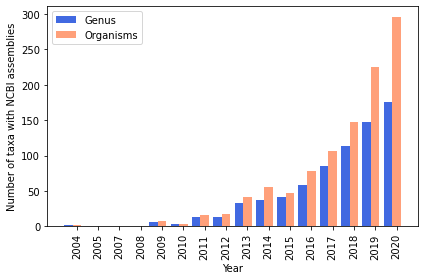

In [101]:
barWidth = 0.4
br1 = np.arange(len(yrs))
br2 = [x + barWidth for x in br1]
plt.bar(br1, gen_yr_list, width=barWidth, color='royalblue', label='Genus')
plt.bar(br2, org_yr_list, width=barWidth, color='lightsalmon', label='Organisms')
plt.xticks([r + barWidth for r in range(len(yrs))], yrs, rotation=90)
plt.xlabel("Year")
plt.ylabel("Number of taxa with NCBI assemblies")
plt.legend()
plt.tight_layout()
plt.savefig(work_dir / 'fig5_2_numbers_org_genus_with_assemblies_per_year.pdf')


### Get counts for new genus/organisms per year

In [106]:
org_dict = {}    # {organism:year_1st_appear}
#gen_dict = {}    # {genus:year_1st_appear}
new_org_yr_list = []
new_gen_yr_list = []
for yr in yrs:
  org_nm_yr = genomes_sp_dt_nr[genomes_sp_dt_nr['Year'] == yr]['Organism Name']
  # check if organism or genus is new new

  idx_qualified = []
  for idx, org in enumerate(org_nm_yr):
    genus = org.split(' ')[0]
    if org not in org_dict:
      org_dict[org]   = yr
      idx_qualified.append(idx)

    # Realize that this is not needed
    #if genus not in gen_dict:
    #  gen_dict[genus] = yr

  # Get qualified rows from org_num_yr
  org_nm_yr_q = org_nm_yr.iloc[idx_qualified]
  #print(org_nm_yr.shape, org_nm_yr_q.shape)

  org_counts_yr, genus_counts_yr = count_num_org_genus(org_nm_yr_q)
  num_org_yr = len(org_counts_yr)
  num_gen_yr = len(genus_counts_yr)
  count_yr_dict[yr] = [num_org_yr, num_gen_yr]
  new_org_yr_list.append(num_org_yr)
  new_gen_yr_list.append(num_gen_yr)

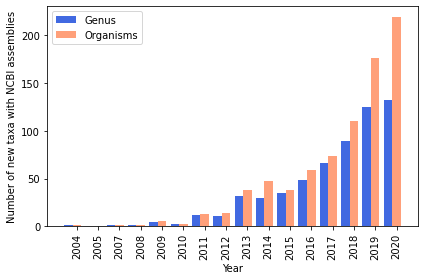

In [107]:
barWidth = 0.4
br1 = np.arange(len(yrs))
br2 = [x + barWidth for x in br1]
plt.bar(br1, new_gen_yr_list, width=barWidth, color='royalblue', label='Genus')
plt.bar(br2, new_org_yr_list, width=barWidth, color='lightsalmon', label='Organisms')
plt.xticks([r + barWidth for r in range(len(yrs))], yrs, rotation=90)
plt.xlabel("Year")
plt.ylabel("Number of new taxa with NCBI assemblies")
plt.legend()
plt.tight_layout()
plt.savefig(work_dir / 'fig5_2_numbers_new_org_genus_with_assemblies_per_year.pdf')
